In [4]:
import sys
import os
from pathlib import Path
sys.path.append(
    os.path.dirname(os.path.abspath('.'))
)
from src import QNet, agent_metrics, show_reward
### path load

import numpy as np
import torch
from torchvision import datasets
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

from shift_funcs import get_funcs, FUNCS, ACTIONS

SEED = 0
device = 'cuda:0'

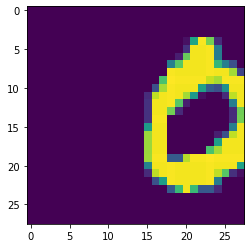

action 1 0.20449491561330413
action 2 0.23639279241108205
action 3 0.016207934154053777
action 4 0.16558941223548243
2


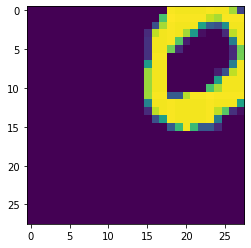

In [7]:
# test
tst_data = np.load('data/ur2/test_dataset.npz')
Dx = tst_data['original_dataset']
Dy = tst_data['test_dataset']
fi_N = tst_data['test_func_labels']
actions = [lambda x: x] + ACTIONS
n = 3
x, y = Dx[n], Dy[n]
y_init = y.copy()

plt.imshow(y_init)
plt.show()
mse = []
for i in range(4):
    o = y_init.copy()
    for _ in range(4):
        o = actions[i + 1](o)
    m = np.mean((o - x)**2)
    mse.append(m)
    print('action', i + 1, m)
a = np.argmin(mse)
print(a)
o = y_init.copy()
for _ in range(4):
    o = actions[a](o)
plt.imshow(o)
plt.show()

In [68]:
err = 0
for n in range(N):
    fi = fi_N[n]
    expected_a_t = 1 if fi == 0 else 2
    x, y = Dx[n], Dy[n]
    y_init = y.copy()
    mse = []
    for a in range(1, 5):
        o = y_init.copy()
        for _ in range(4):
            o = actions[a](o)
        mse.append(np.mean((o - x)**2))
    a_t = np.argmin(mse)
    if a_t != expected_a_t:
        err += 1
err / N

0.0

1
1
3
3
3
[1, 1, 3, 3, 3]


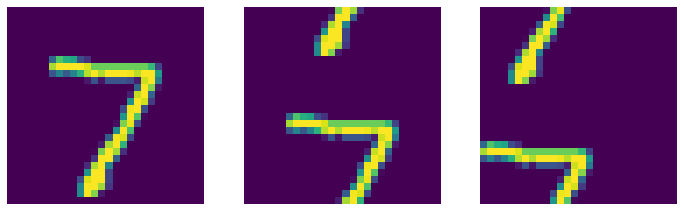

In [52]:
print(actual_best_actions)
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(x)
axes[0].axis('off')

axes[1].imshow(y_init)
axes[1].axis('off')

axes[2].imshow(y)
axes[2].axis('off')

plt.show()

In [48]:
# test
tst_data = np.load('data/ur/test_dataset.npz')
Dx = tst_data['original_dataset']
Dy = tst_data['test_dataset']
fi_N = tst_data['test_func_labels']
actions = [lambda x: x] + ACTIONS
count = 0
N = Dx.shape[0]
for n in range(N):
    fi = fi_N[n]
    x, y = Dx[n], Dy[n]
    expected_actions = []
    if i == 0:  # 上
        expected_actions = [1] * 4
    elif i == 3:  # 右
        expected_actions = [2] * 4
    actual_best_actions = []
    for t in range(5):
        # 全部求める
        mse = []
        for a in range(5):
            z = actions[a](y.copy())
            mse.append(np.mean((z - x)**2))
        a_t = np.argmin(mse)
        actual_best_actions.append(a_t)
        y = actions[a_t](y)
    if 0 in actual_best_actions:
        actual_best_actions.remove(0)
    if expected_actions == actual_best_actions:
        count += 1
count / N

0.0

2 channel weight: =  0.05
RESULT_PATH results/ur3/channel02_weight005_seed00


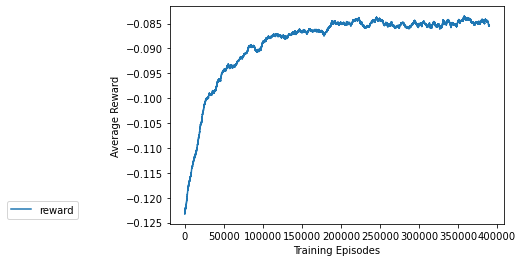

TEST_DATASET_PATH data/ur2/test_dataset.npz
0.16264913313364907
MODEL_PATH results/ur3/channel02_weight005_seed00/Qnet020000.pth



MSE(test_dataset, agent_outputs) =  0.1266729656591368


In [ ]:
# 実験条件を指定
SEED = 0
data_dir = 'ur2'
outdir = 'ur3'
for (CHANNEL, WEIGHT) in [
#     [2, 0.00],
    [2, 0.05],
]:
    print(CHANNEL, 'channel', 'weight: = ', WEIGHT)
    RESULT_PATH = Path('results/%s' % outdir) / ('channel%02d_weight%03d_seed%02d' % (CHANNEL, int(100*WEIGHT), SEED))
    print("RESULT_PATH", str(RESULT_PATH))

    funcs = FUNCS
    actions = [lambda x: x] + ACTIONS

    # see reward
    ax = plt.subplot(111)
    ma = show_reward(ax, dir_path=str(RESULT_PATH), mono=False, n=10000, label='reward')
    plt.show()

    # load test data
    TEST_DATASET_PATH = 'data/%s/test_dataset.npz' % data_dir
    print("TEST_DATASET_PATH", TEST_DATASET_PATH)
    test_dataset_context = np.load(TEST_DATASET_PATH)
    Dx = test_dataset_context['original_dataset']
    Dx = torch.from_numpy(Dx)
    Dy = test_dataset_context['test_dataset']
    Dy = torch.from_numpy(Dy)

    print(torch.mean((Dy - Dx)**2).item())
    # load model
    Qnet = QNet(c=CHANNEL, m=[20, 20, len(actions)])
    MODEL_PATH = RESULT_PATH / 'Qnet020000.pth'
    print('MODEL_PATH', str(MODEL_PATH))
    Qnet.load_state_dict(
        torch.load(str(MODEL_PATH))
    )
    
    METRIC_PATH = list(RESULT_PATH.glob('metrics*.npy'))
    if len(METRIC_PATH) > 0:
        result = np.load(str(METRIC_PATH[0]))
    else:
        result = agent_metrics(Dy, Dx, Qnet, actions, channel=CHANNEL)
    mse = result[:, -1].mean()
    print('MSE(test_dataset, agent_outputs) = ', mse)
    
    fig, axes = plt.subplots(10, 10, figsize=(10, 10))
    for i in range(0, 10, 2):
        for j in range(10):
            y = Dy[10 * i + j]
            x = Dx[10 * i + j]
            took_act = result[10 * i + j, :-1]
            for a in took_act:
                y = actions[int(a)](y)
            x_hat = y
            
            axes[i, j].imshow(x_hat)
            axes[i, j].set_title('-' * 10)
            axes[i + 1, j].imshow(x)
    plt.show()
    fig, axes = plt.subplots(1, 5, figsize=(20, 4))
    for j in range(5):
        axes[j].set_title('%d' % (j + 1))
        freq, _, patches = axes[j].hist(result[:, j], bins=np.arange(6) - 0.5, density=True)
        patches[freq.argsort()[::-1][0]].set_fc('r')
        patches[freq.argsort()[::-1][1]].set_fc('r')
        axes[j].set_xticks(np.arange(5))
        axes[j].set_xticklabels(list('nudlr'))
    plt.show()
    print()
    
    # 上下左右

    if len(METRIC_PATH) == 0:
        np.save(str(RESULT_PATH / f'metrics{int(1000*mse):03d}.npy'), result)
    print('-' * 20)
    print()

1 channel weight: =  0.0
RESULT_PATH results/shift1/diag_xfyf/channel01_weight000_seed00


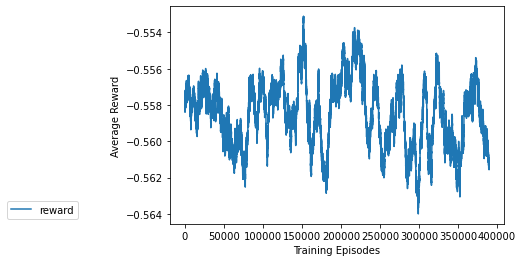

2 channel weight: =  0.05
RESULT_PATH results/shift1/diag_xfyf/channel02_weight005_seed00


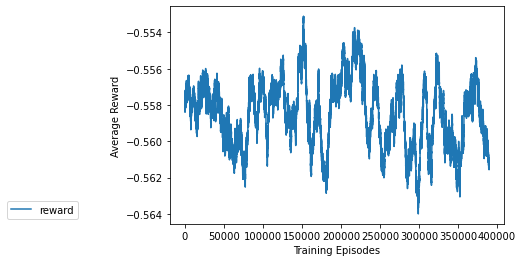

In [4]:
# 実験条件を指定
# 行動候補: 「左, 上, 右, 下」
SL = 1
SEED = 0
#['xfyf','xfyf_xbyb']
for DT in tqdm(['xfyf']):
    for (CHANNEL, WEIGHT) in [
        [1, 0.00],
        [2, 0.05],
    ]:
        print(CHANNEL, 'channel', 'weight: = ', WEIGHT)
        RESULT_PATH = os.path.join(
            'results/shift%d/diag_%s/' % (SL, DT),
            'channel%02d_weight%03d_seed%02d' % (CHANNEL, int(100*WEIGHT), SEED)
        )
        print("RESULT_PATH", RESULT_PATH)

        # 変換と行動候補
        funcs = [get_funcs(*delta) for delta in [
            (SL, SL),
            (SL, -SL),
            (-SL, SL),
            (-SL, -SL),
        ]]
        actions = [lambda x: x] + [f[1] for f in funcs]

        # see reward
        ax = plt.subplot(111)
        ma = show_reward(ax, dir_path=RESULT_PATH, mono=False, n=10000, label='reward')
        plt.show()

#         for TEST_FUNC in ['0', '1', '03']:
#             print('test func', TEST_FUNC)
#             # load test data
#             TEST_DATASET_PATH = 'data/shift%d/test_%s_dataset.npz' % (SL, TEST_FUNC)
#             print("TEST_DATASET_PATH", TEST_DATASET_PATH)
#             test_dataset_context = np.load(TEST_DATASET_PATH)
#             originals = test_dataset_context['original_dataset']
#             test_dataset = test_dataset_context['test_dataset']
#             test_func_labels = test_dataset_context['test_func_labels']
#             test_dataset = torch.from_numpy(test_dataset)
#             originals = torch.from_numpy(originals)

#             # load model
#             Qnet = QNet(c=CHANNEL, m=[20, 20, len(actions)])
#             MODEL_PATH = os.path.join(RESULT_PATH, 'Qnet020000.pth')
#             print('MODEL_PATH', MODEL_PATH)
#             Qnet.load_state_dict(
#                 torch.load(MODEL_PATH)
#             )
#             result = agent_metrics(test_dataset, originals, Qnet, actions, channel=CHANNEL)
#             mse = result[:, -1].mean()
#             print('MSE(test_dataset, agent_outputs) = ', mse)
#             print('action frequency')
#             print(np.histogram(result[:, -1], bins=np.arange(6) - 0.5, density=True))

#             METRIC_PATH = os.path.join(RESULT_PATH, f'metrics{TEST_FUNC}_{int(1000*mse):03d}')
#             print("METRIC_PATH", METRIC_PATH)
#             np.save(METRIC_PATH, result)
#             print('-' * 20)
#             print()